# Music Genre Recognition on GTZAN

This file should be used in Google Colab otherwise you might face issues during running the code on your local machine. Also, **it is important to note that you need to run the code with GPU and High-RAM which prevents you to face errors.** This is completely tested and should work for you as well. Even if it does not work for you we can setup a session to help you make it work.

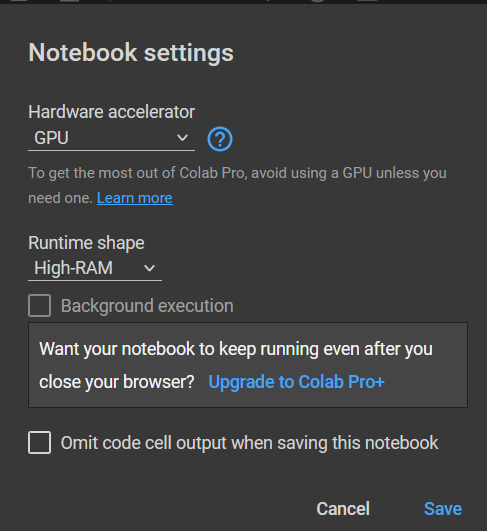

# Clone the Repository

We have used Github to store our code resource. The link to our repository is available on [Genrecog Github Repository](https://github.com/ConcoLab/genrecog). However, this code pulls the latest version of Genrecog for you. Also, you need to install SpeechBrain since it is not available as a default library on Colab.

In [ ]:
%%capture
%cd /content
!git clone https://github.com/ConcoLab/genrecog.git
%cd /content/genrecog

%pip install speechbrain

#Download Dataset

**Do not forget to uncomment one of the methods to make it work.**

In the next step you need to download the `train.npz` and `test.npz` dataset to the `dataset/npz_files/`.

Please note that we tried `gdown` to download the datasets from Drive, however, it is not stable and we do not recommend it. You can uncomment the first cell to see if `gdown` works fine. If it works, then keep the second cell as commented. Otherwise you can use the second cell.

The other cell downloads the dataset from our storage on Concordia Storage.

 This can be done manually by using following links:

**train.npz**

[Concordia Storage](https://users.encs.concordia.ca/~a_hraf/train.npz) or [Google Drive](https://drive.google.com/file/d/1gPI8Jd94jCniZLHC2-KLVHPw0HlfNvFx/view?usp=sharing)



**test.npz**

[Concordia Storage](https://users.encs.concordia.ca/~a_hraf/test.npz) or [Google Drive](https://drive.google.com/file/d/1ZkJwOQPGR_okWNAPbJ8_6YtDOCog5fg3/view?usp=sharing)





In [ ]:
# You should see two files on dataset/npz_files
# if they are downloaded well.

# %cd /content/genrecog/dataset/npz_files
# !gdown --id 1ZkJwOQPGR_okWNAPbJ8_6YtDOCog5fg3
# !gdown --id 1gPI8Jd94jCniZLHC2-KLVHPw0HlfNvFx
# %cd /content/genrecog
# %ls /content/genrecog/dataset/npz_files

In [39]:
# You can try the second way. Uncomment to make it work.

# !wget -O dataset/npz_files/train.npz -c "https://users.encs.concordia.ca/~a_hraf/train.npz"
# !wget -O dataset/npz_files/test.npz -c "https://users.encs.concordia.ca/~a_hraf/test.npz"

--2022-04-11 18:46:18--  https://users.encs.concordia.ca/~a_hraf/train.npz
Resolving users.encs.concordia.ca (users.encs.concordia.ca)... 132.205.96.37
Connecting to users.encs.concordia.ca (users.encs.concordia.ca)|132.205.96.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2222669398 (2.1G)
Saving to: ‘dataset/npz_files/train.npz’

dataset/npz_files/t 100%[===================>]   2.07G  2.11MB/s    in 16m 51s 

2022-04-11 19:03:09 (2.10 MB/s) - ‘dataset/npz_files/train.npz’ saved [2222669398/2222669398]

--2022-04-11 19:03:09--  https://users.encs.concordia.ca/~a_hraf/test.npz
Resolving users.encs.concordia.ca (users.encs.concordia.ca)... 132.205.96.37
Connecting to users.encs.concordia.ca (users.encs.concordia.ca)|132.205.96.37|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



# Loading The Libraries

We used publicly available libraries and our developed libraries which are available on Github.

In [41]:
# Essntial Libraries
from genrecog.preprocess.preprocessor import Preprocessor
from genrecog.nnet.CNN import Conv1d, VanillaConv1d, VanillaConv2d
from genrecog.nnet.RNN import VanillaRNN, LSTM, GRU
from genrecog.tools.trainer import CNNFbankTrainer, RNNFbankTrainer, SklearnTrainer, KmeansTrainer
import torch
from torch.utils.data import TensorDataset, DataLoader 
import datetime
from genrecog.preprocess.feature import Feature
from IPython.display import Audio
import matplotlib.pyplot as plt



torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Setting the Dataset Path

You can use the following cell to set the path to the datasets. If you weren't able to download the dataset, you can easily put it on your `Google Drive` and mont your drive. Then you can use that path to make the code work. Do not forget to update the following path.

In [42]:
train_preprcessor = Preprocessor('dataset/npz_files/train.npz')
test_preprcessor = Preprocessor('dataset/npz_files/test.npz')


# Processed Data
The following code shows that we actually using a set of musics which are converted to waves and then we use Fast Fourier Transform (FFT) with using a library available in speechbrain library (FBank) to extract the features.

In [43]:
# Load a sample dataset for demonstration purposes
X_test, y_test = test_preprcessor.as_shuffled_numpy()

## Listen a Part of a Music
Each sample in X_test is a music sample that you can listen to and they have a length of 7 seconds.

In [44]:
Audio(X_test[0], rate=22050)

Also you can see the wave resulting from each sample that is gotten from the music.

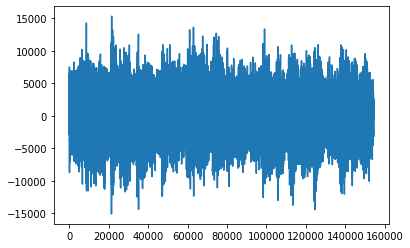

In [45]:
plt.plot(X_test[0])

Now, it is the time to extract the features off the sample. So, you can see that each sample is turned to a two-dimensional array containig FFT samples.

In [46]:
feature_maker = Feature()
print("Shape of the music waves:", X_test.shape)
X_test_features = feature_maker.numpy_fbank_features(X_test)
print("Resulted sample features shape:", X_test_features.shape)


Shape of the music waves: (400, 154350)
Resulted sample features shape: (400, 702, 40)


And finally we can plot the features:

Text(0.5, 0, 'time')

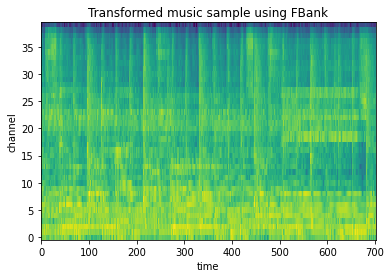

In [47]:
plt.imshow(X_test_features[0].T, 
           cmap='viridis', 
           interpolation='nearest', 
           aspect='auto', origin='left, bottom')
plt.title('Transformed music sample using FBank')
plt.ylabel('channel')
plt.xlabel('time')

# 1. Neural Network Data Preparation

To train neural network models, we need to define the DataLoaders. So, we have prepared three different DataLoaders for training, validation and test. This allowed us to reuse the same method for both RNN and CNN at the further steps. 

**It is important to note that we set the size of batches to 400 and you might need to change it due to RAM constraints.**

In [48]:
batch_size = 400 # If your RAM does not support you can replace it with 100

X, y = train_preprcessor.as_shuffled_torch()
X_test, y_test = test_preprcessor.as_shuffled_torch()

dataset = TensorDataset(X.to(device), y.to(device))
validation_dataset, train_dataset = torch.utils.data.random_split(dataset, (400, 3200))
test_dataset = TensorDataset(X_test.to(device), y_test.to(device))

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
validation_dataloader = DataLoader(validation_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

Also, we took 100 as the numnber of epochs in all of the trained models before deciding for overfitting. Here you are able to set it to 100 if you'd like to compare our stated results with this notebook. You would be able to see all the epochs' information after each training process.

In [49]:
num_epochs=10 # You can change it to 100 for closer results

# 2. Recurrent Neural Network

We have decided to train different models on RNN to see which of them works better than the others. So, we fixed the following hyperparameters and change the RNN core functions. The layer that are used include VanillaRNN, LSTM, and GRU. Also, for each of them we used two different variations. One was taking the last hidden layer as the output of the forward function and the other was taking the average of all hidden layers as the output function.

In [50]:
hidden_size = 128
num_layers = 5
input_size = 40
output_dim = 10
time_sequence = 702
lr = 0.001

## 2.1. VanillaRNN with Using Last Layer of the Hidden Layers

In [51]:
%reset_selective -f model
%reset_selective -f trainer
%reset_selective -f optimizer
%reset_selective -f loss
loss = torch.nn.CrossEntropyLoss()
model = VanillaRNN(
    input_size=input_size, 
    time_sequence=time_sequence,
    hidden_size=hidden_size, 
    num_layers=num_layers, 
    output_dim=output_dim,
    use_mean=False
    ).to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print(model)
trainer = RNNFbankTrainer(
    model=model, 
    optimizer=optimizer, 
    loss=loss, 
    train_dataloader=train_dataloader, 
    validation_dataloader=validation_dataloader, 
    num_epochs=num_epochs)
trainer.train()
trainer.plot_loss("training and validation loss")
trainer.plot_accuracies("training and validation accuracy")
trainer.plot_confusion_matrix(test_dataloader, 'confusion matrix')
y_pred, y_eval, loss, accuracy = trainer.eval(test_dataloader)
print("accuracy: ", accuracy * 100)

VanillaRNN(
  (batch_norm_input): BatchNorm1d(702, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rnn): RNN(40, 128, num_layers=5, batch_first=True)
  (batch_norm_hidden): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear): Linear(in_features=128, out_features=10, bias=True)
)


KeyboardInterrupt: ignored

## 2.2. VanillaRNN with Using Mean Value of All Hidden Layers

In [ ]:
%reset_selective -f model
%reset_selective -f trainer
%reset_selective -f optimizer
%reset_selective -f loss
loss = torch.nn.CrossEntropyLoss()
model = VanillaRNN(
    input_size=input_size, 
    time_sequence=time_sequence,
    hidden_size=hidden_size, 
    num_layers=num_layers, 
    output_dim=output_dim,
    use_mean=True
    ).to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print(model)
trainer = RNNFbankTrainer(
    model=model, 
    optimizer=optimizer, 
    loss=loss, 
    train_dataloader=train_dataloader, 
    validation_dataloader=validation_dataloader, 
    num_epochs=num_epochs)
trainer.train()
trainer.plot_loss("training and validation loss")
trainer.plot_accuracies("training and validation accuracy")
trainer.plot_confusion_matrix(test_dataloader, 'confusion matrix')
y_pred, y_eval, loss, accuracy = trainer.eval(test_dataloader)
print("accuracy: ", accuracy * 100)

## 2.3. LSTM with Using Last Layer of Hidden Layers

In [ ]:
%reset_selective -f model
%reset_selective -f trainer
%reset_selective -f optimizer
%reset_selective -f loss
loss = torch.nn.CrossEntropyLoss()
model = LSTM(
    input_size=input_size, 
    time_sequence=time_sequence,
    hidden_size=hidden_size, 
    num_layers=num_layers, 
    output_dim=output_dim,
    use_mean=False
    ).to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print(model)
trainer = RNNFbankTrainer(
    model=model, 
    optimizer=optimizer, 
    loss=loss, 
    train_dataloader=train_dataloader, 
    validation_dataloader=validation_dataloader, 
    num_epochs=num_epochs)
trainer.train()
trainer.plot_loss("training and validation loss")
trainer.plot_accuracies("training and validation accuracy")
trainer.plot_confusion_matrix(test_dataloader, 'confusion matrix')
y_pred, y_eval, loss, accuracy = trainer.eval(test_dataloader)
print("accuracy: ", accuracy * 100)

## 2.4. LSTM with Using Mean Value of All Hidden Layers

In [ ]:
%reset_selective -f model
%reset_selective -f trainer
%reset_selective -f optimizer
%reset_selective -f loss
loss = torch.nn.CrossEntropyLoss()
model = LSTM(
    input_size=input_size, 
    time_sequence=time_sequence,
    hidden_size=hidden_size, 
    num_layers=num_layers, 
    output_dim=output_dim,
    use_mean=True
    ).to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print(model)
trainer = RNNFbankTrainer(
    model=model, 
    optimizer=optimizer, 
    loss=loss, 
    train_dataloader=train_dataloader, 
    validation_dataloader=validation_dataloader, 
    num_epochs=num_epochs)
trainer.train()
trainer.plot_loss("training and validation loss")
trainer.plot_accuracies("training and validation accuracy")
trainer.plot_confusion_matrix(test_dataloader, 'confusion matrix')
y_pred, y_eval, loss, accuracy = trainer.eval(test_dataloader)
print("accuracy: ", accuracy * 100)

## 2.5. GRU with Using Last Layer of the Hidden Layers

In [ ]:
%reset_selective -f model
%reset_selective -f trainer
%reset_selective -f optimizer
%reset_selective -f loss
loss = torch.nn.CrossEntropyLoss()
model = GRU(
    input_size=input_size, 
    time_sequence=time_sequence,
    hidden_size=hidden_size, 
    num_layers=num_layers, 
    output_dim=output_dim,
    use_mean=False
    ).to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print(model)
trainer = RNNFbankTrainer(
    model=model, 
    optimizer=optimizer, 
    loss=loss, 
    train_dataloader=train_dataloader, 
    validation_dataloader=validation_dataloader, 
    num_epochs=num_epochs)
trainer.train()
trainer.plot_loss("training and validation loss")
trainer.plot_accuracies("training and validation accuracy")
trainer.plot_confusion_matrix(test_dataloader, 'confusion matrix')
y_pred, y_eval, loss, accuracy = trainer.eval(test_dataloader)
print("accuracy: ", accuracy * 100)

## 2.6. GRU with Using Mean Value of All Hidden Layers

In [ ]:
%reset_selective -f model
%reset_selective -f trainer
%reset_selective -f optimizer
%reset_selective -f loss
loss = torch.nn.CrossEntropyLoss()
model = GRU(
    input_size=input_size, 
    time_sequence=time_sequence,
    hidden_size=hidden_size, 
    num_layers=num_layers, 
    output_dim=output_dim,
    use_mean=True
    ).to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print(model)
trainer = RNNFbankTrainer(
    model=model, 
    optimizer=optimizer, 
    loss=loss, 
    train_dataloader=train_dataloader, 
    validation_dataloader=validation_dataloader, 
    num_epochs=num_epochs)
trainer.train()
trainer.plot_loss("training and validation loss")
trainer.plot_accuracies("training and validation accuracy")
trainer.plot_confusion_matrix(test_dataloader, 'confusion matrix')
y_pred, y_eval, loss, accuracy = trainer.eval(test_dataloader)
print("accuracy: ", accuracy * 100)

# 3. Convolutional Neural Network
After examining the RNN to train a classifier for our project, we have decided to use CNN to compare our result with. We have trained three different models for our CNN including VanillaConv1d, VanillaConv1d, Conv2d, which each of them becomes more complex in terms of architecture. Also, we tried to keep the architecture close to RNN which makes the results compareable. As of this reason, we used learning rate equal to 0.001 for all CNN models.


In [ ]:
lr = 0.001

## 3.1. VanillaConv1d 

In [ ]:
%reset_selective -f model
%reset_selective -f trainer
%reset_selective -f optimizer
%reset_selective -f loss
model = VanillaConv1d().to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print(model)
trainer = CNNFbankTrainer(
    model=model, 
    optimizer=optimizer, 
    loss=loss, 
    train_dataloader=train_dataloader, 
    validation_dataloader=validation_dataloader, 
    num_epochs=num_epochs)
trainer.train()
trainer.plot_loss("training and validation loss")
trainer.plot_accuracies("training and validation accuracy")
trainer.plot_confusion_matrix(test_dataloader, 'confusion matrix')
y_pred, y_eval, loss, accuracy = trainer.eval(test_dataloader)
print("accuracy: ", accuracy * 100)

## 3.2. Conv1d

In [ ]:
%reset_selective -f model
%reset_selective -f trainer
%reset_selective -f optimizer
%reset_selective -f loss
loss = torch.nn.CrossEntropyLoss()
model = Conv1d().to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
trainer = CNNFbankTrainer(
    model=model, 
    optimizer=optimizer, 
    loss=loss, 
    train_dataloader=train_dataloader, 
    validation_dataloader=validation_dataloader, 
    num_epochs=num_epochs)
trainer.train()
trainer.plot_loss("training and validation loss")
trainer.plot_accuracies("training and validation accuracy")
trainer.plot_confusion_matrix(test_dataloader, 'confusion matrix')
y_pred, y_eval, loss, accuracy = trainer.eval(test_dataloader)
print("accuracy: ", accuracy * 100)

## 3.3. VanillaConv2d

In [ ]:
%reset_selective -f model
%reset_selective -f trainer
%reset_selective -f optimizer
%reset_selective -f loss
loss = torch.nn.CrossEntropyLoss()
model = VanillaConv2d().to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
trainer = CNNFbankTrainer(
    model=model, 
    optimizer=optimizer, 
    loss=loss, 
    train_dataloader=train_dataloader, 
    validation_dataloader=validation_dataloader, 
    num_epochs=num_epochs)
trainer.train()
trainer.plot_loss("training and validation loss")
trainer.plot_accuracies("training and validation accuracy")
trainer.plot_confusion_matrix(test_dataloader, 'confusion matrix')
y_pred, y_eval, loss, accuracy = trainer.eval(test_dataloader)
print("accuracy: ", accuracy * 100)

In [ ]:
# Free Memory :)
%reset_selective -f model
%reset_selective -f trainer
%reset_selective -f optimizer
%reset_selective -f loss

# 4. Multiple Model Training
In this part, we have written a class which is responsible to train some of the `sklearn` models. So, we can pass a dictionary of various models with different parameters to a the class and it trains them all one by one. This was helpful for hyperparameter search.




## 4.1. Dataset as Numpy
Since `Sklearn` only works with Numpy, we need to redefine the features as Numpy arrays instead of torch Tensors. Also, in the previous parts (NN), the feature extraction was done during loading the dataset in the DataLoader to save more memory. Here we need to convert the Numpy arrays to FBank Featurs and then use them to train models.

In [52]:
X,y = train_preprcessor.as_shuffled_numpy()
X_test, y_test = test_preprcessor.as_shuffled_numpy()

feature_maker = Feature()
X_features = feature_maker.numpy_fbank_features(X).reshape(-1,702*40)
X_test_features = feature_maker.numpy_fbank_features(X_test).reshape(-1,702*40)

## 4.2. Defining Models and Parameters

The following dictionary shows how easy we can create various models based on their name and their paramters. It is possible to have i.e. multiple SVMs with different hyperparameters at the same time. 

In [53]:
models = {
    "mlp": {
        "name": "mlp",
        "parameters": {
            "hidden_layer_sizes": (128,128,128,128,128),
            "solver": "adam",
            "max_iter": 100,
            "early_stopping": True,
         }
    },
    "svm_ovo": {
          "name": "svm",
          "parameters": {
            "decision_function_shape":"ovo"
          }
    },
    "svm_ovr": {
          "name": "svm",
          "parameters": {
            "decision_function_shape":"ovr"
          }
    },
    "decision_tree": {
          "name": "decision_tree",
          "parameters": {
          }
    },
    "random_forest": {
          "name": "random_forest",
          "parameters": {
          }
    },

}

## Training the Defined Models

We can pass the models as a parameter to the defined class and then we can set three more variables. We can ask to use PCA with a specific number of components or we can have MinMaxScaler normalization if it is needed. So, it helps us to investigate the effect of both in addition to hyperparamter search.

In [54]:
trainer = SklearnTrainer(models=models, use_norm=True, use_pca=True, pca_size=200)
trainer.train(X_features, y)

Training MLP
Model information:  MLPClassifier(early_stopping=True, hidden_layer_sizes=(128, 128, 128, 128, 128),
              max_iter=100)
Training SVM_OVO
Model information:  SVC(decision_function_shape='ovo')
Training SVM_OVR
Model information:  SVC()
Training DECISION_TREE
Model information:  DecisionTreeClassifier()
Training RANDOM_FOREST
Model information:  RandomForestClassifier()


## Evaluating the Models

In the last step, we can evaluate the model and retrieve the information for each model such as accuracy data.

In [55]:
evaluations = trainer.eval(X_test_features, y_test)

Evaluating MLP
Evaluating SVM_OVO
Evaluating SVM_OVR
Evaluating DECISION_TREE
Evaluating RANDOM_FOREST
All models are evaluated.


Also, we can generate the classification report for all models at the same time and compare them. Don't forget to evaluate first and then pull these information.

In [56]:
trainer.classification_report();

CLASSIFICATION REPORT FOR MLP:

              precision    recall  f1-score   support

     country       0.65      0.46      0.54        56
      reggae       0.40      0.35      0.37        46
       metal       0.53      0.50      0.51        42
         pop       0.90      0.88      0.89        41
   classical       0.75      0.94      0.83        32
       disco       0.35      0.45      0.39        31
      hiphop       0.28      0.37      0.31        30
       blues       0.28      0.33      0.30        33
        jazz       0.55      0.59      0.57        37
        rock       0.50      0.38      0.43        52

    accuracy                           0.52       400
   macro avg       0.52      0.53      0.52       400
weighted avg       0.53      0.52      0.52       400

CLASSIFICATION REPORT FOR SVM_OVO:

              precision    recall  f1-score   support

     country       0.57      0.37      0.45        62
      reggae       0.38      0.36      0.37        42
       met

Moreover, we will have access to confusion matrix for all models upon request.

CONFUSION MATRIX FOR MLP:



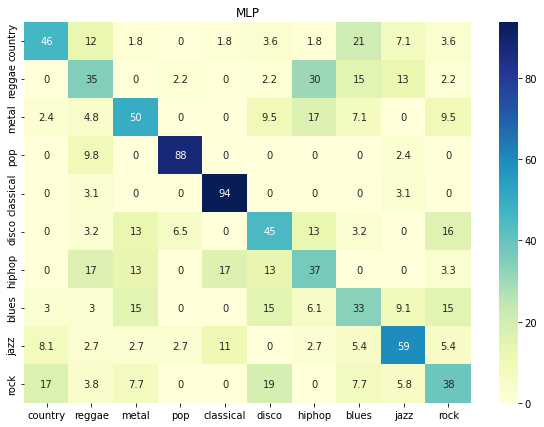

CONFUSION MATRIX FOR SVM_OVO:



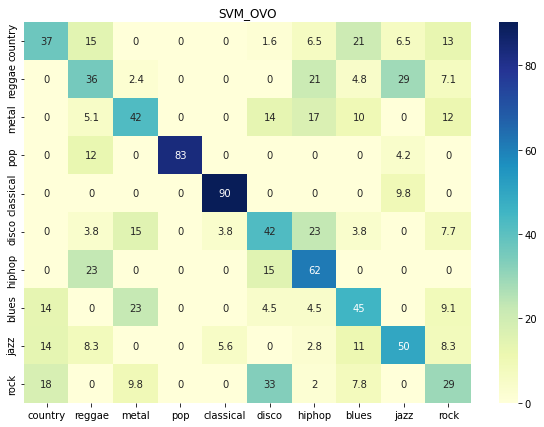

CONFUSION MATRIX FOR SVM_OVR:



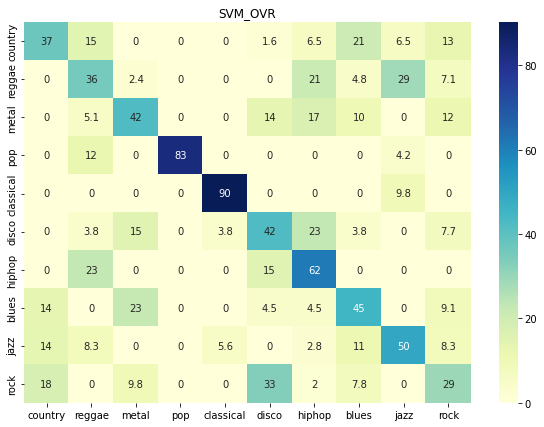

CONFUSION MATRIX FOR DECISION_TREE:



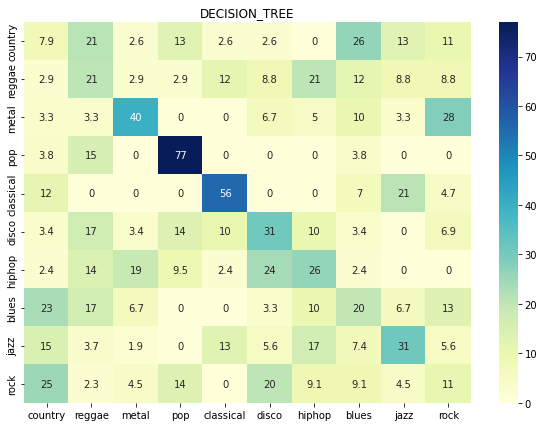

CONFUSION MATRIX FOR RANDOM_FOREST:



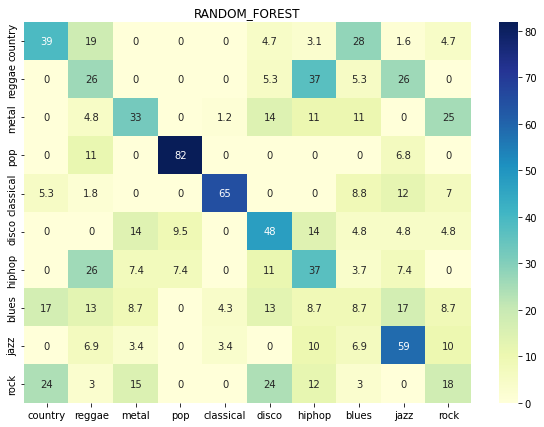

In [58]:
trainer.plot_confusion_matrix()

# 5. KMeans Clustering
We have used KMeans as part of our project to see if we can define clusters properly with in the samples and we check to see if we can assign each cluster to a set of genres. More details are available on the report.


Adjusted Rand Score: 0.162


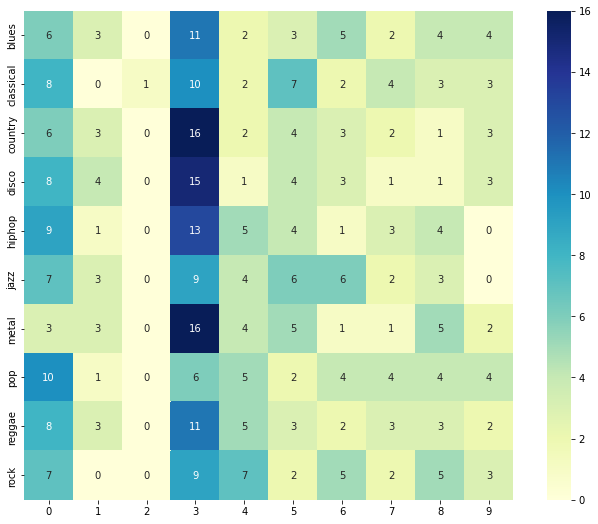

In [59]:
trained_genres = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
model = KmeansTrainer(trained_genres)
model.train(X_features, y)
y_pred_features = model.eval(X_test_features, y_test)
model.accuracy_score(X_test_features, y_test)
model.plot_adjusted_matrix(X_test_features, y_test)